## Importing necessary libraries

In [144]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [19]:
df = pd.read_csv("../data/shampoo.csv")

In [20]:
df.head()

,"Month;""Sales"""
0,01-01;266
1,01-02;145.9
2,01-03;183.1
3,01-04;119.3
4,01-05;180.3


## Data Preparation

In [21]:
df["Month"] = df['Month;"Sales"'].str.slice(0,5)

In [22]:
df["Month"] = pd.to_datetime(df['Month'], format='%y-%m')

In [23]:
df["Sales"] = df['Month;"Sales"'].str.slice(6,)

In [24]:
df.set_index('Month',inplace=True)

In [26]:
df.drop(columns=['Month;"Sales"'],inplace=True)

In [27]:
df.head()

,Sales
Month,
2001-01-01,266
2001-02-01,145.9
2001-03-01,183.1
2001-04-01,119.3
2001-05-01,180.3


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36 entries, 2001-01-01 to 2003-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Sales   36 non-null     object
dtypes: object(1)
memory usage: 576.0+ bytes


In [29]:
df['Sales']=df['Sales'].astype(float)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36 entries, 2001-01-01 to 2003-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   36 non-null     float64
dtypes: float64(1)
memory usage: 576.0 bytes


## Data Visualization

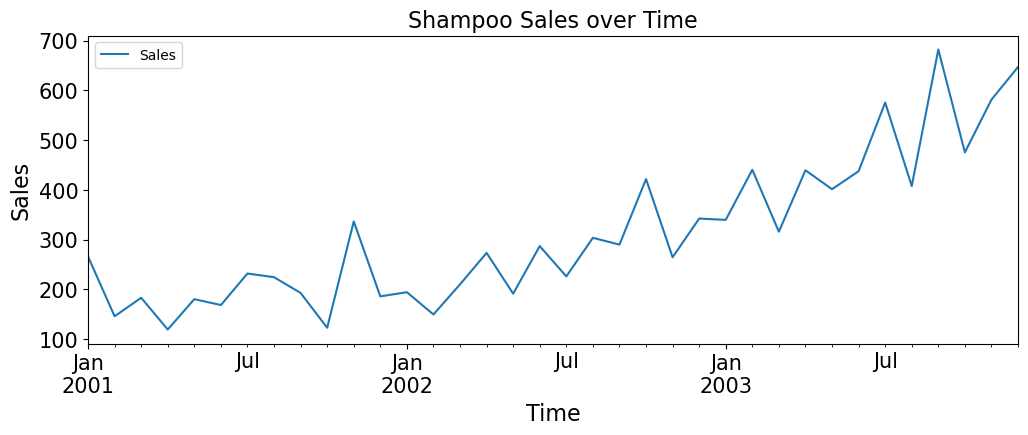

In [145]:
df.plot(figsize=(12,4))
plt.ylabel('Sales')
plt.title("Shampoo Sales over Time")
plt.xlabel('Time')
plt.show()

## EDA

In [34]:
round(df.describe(),3)

,Sales
count,36.000
mean,312.600
std,148.937
min,119.300
25%,192.450
50%,280.150
75%,411.100
max,682.000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


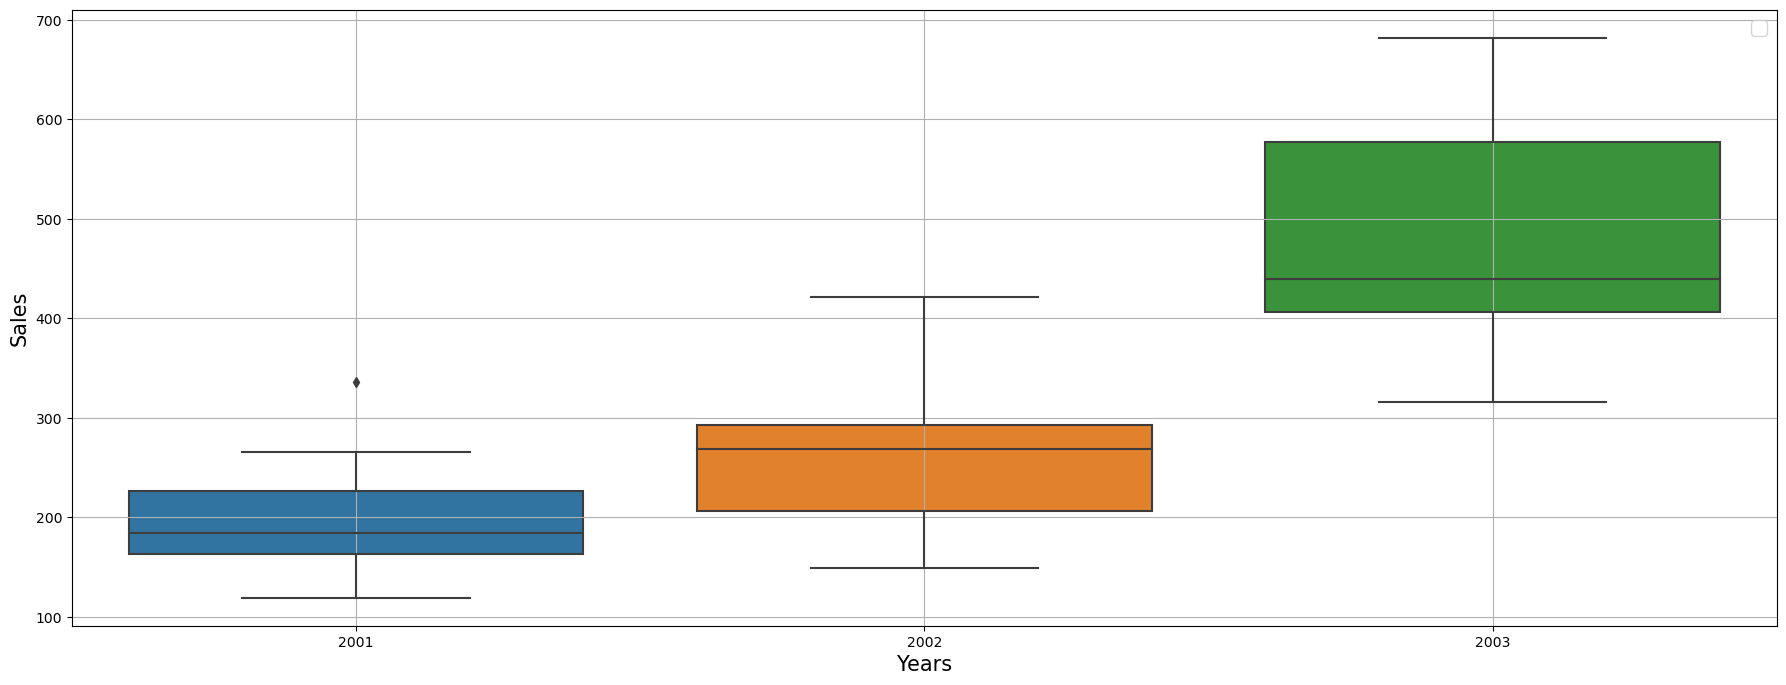

In [37]:
_, ax = plt.subplots(figsize=(22,8))
sns.boxplot(x = df.index.year,y = df.values[:,0],ax=ax)
plt.grid();
plt.xlabel('Years',fontsize=15)
plt.ylabel('Sales',fontsize=15)
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.legend(fontsize="x-large")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


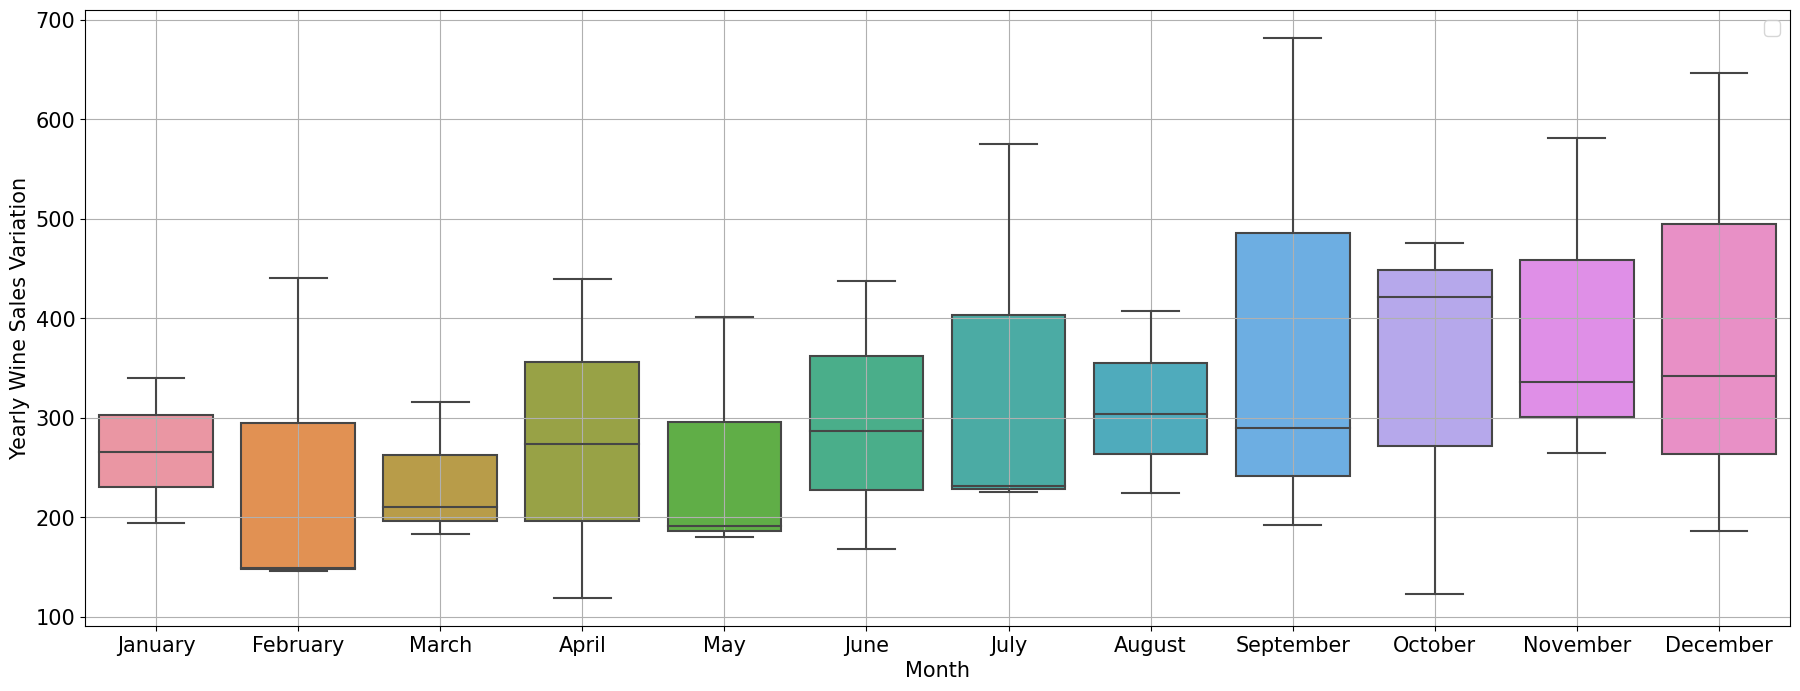

In [39]:
## Monthly Boxplot
_, ax = plt.subplots(figsize=(22,8))
sns.boxplot(x = df.index.month_name(),y = df.values[:,0],ax=ax)

plt.grid()
plt.xlabel('Month',fontsize=15)
plt.ylabel('Yearly Wine Sales Variation',fontsize=15)
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.legend(fontsize="x-large")

#### Decomposition

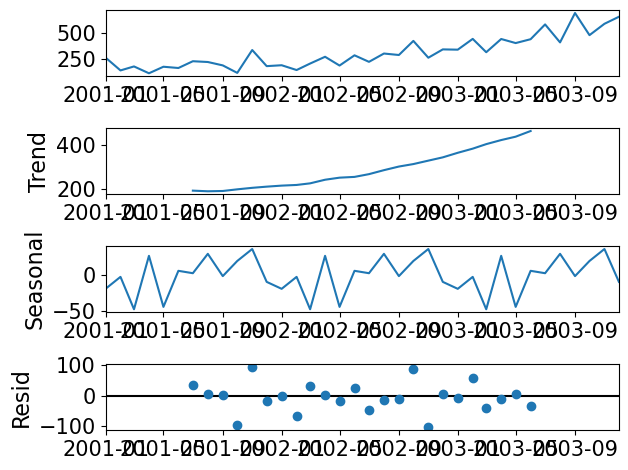

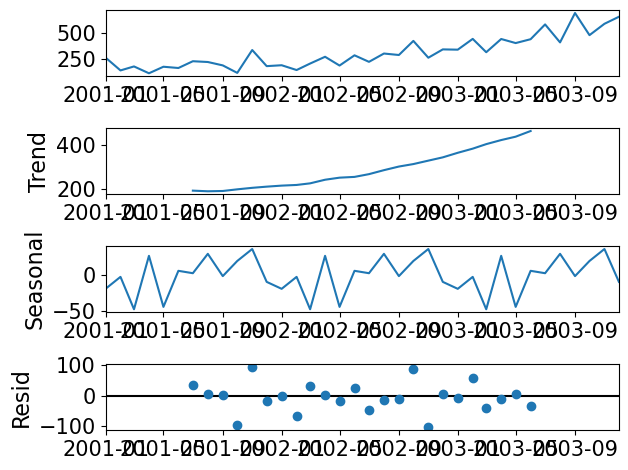

In [149]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df,model='additive')
decomposition.plot()

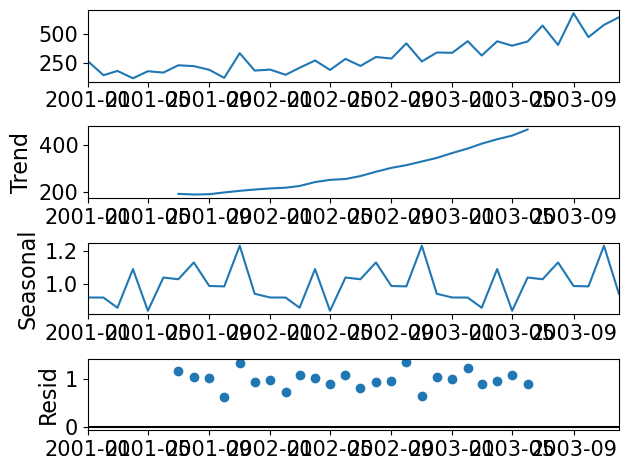

In [147]:
decomposition = seasonal_decompose(df,model='multiplicative')
decomposition.plot()
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16

In the multiplicative model, We observe that the trend and seasonality are clearly separated and the scale of noise is small. In the additive model, there are outliers present in the residual. So the series is multiplicative.

# Differencing

In [62]:
from statsmodels.tsa.stattools import adfuller
test_result=adfuller(df['Sales'])

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [82]:
adfuller_test(df['Sales'])

ADF Test Statistic : 3.0601420836411815
p-value : 1.0
#Lags Used : 10
Number of Observations Used : 25
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


We will have to difference data to make it stationary

In [83]:
data = df.copy()

In [84]:
data['Sales First Difference']=data['Sales']-data['Sales'].shift(1)
data['Seasonal First Difference'] = data['Sales'] - data['Sales'].shift(12)

In [85]:
adfuller_test(data['Sales First Difference'].dropna())

ADF Test Statistic : -7.249074055553854
p-value : 1.7998574141687034e-10
#Lags Used : 1
Number of Observations Used : 33
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


<AxesSubplot:xlabel='Month'>

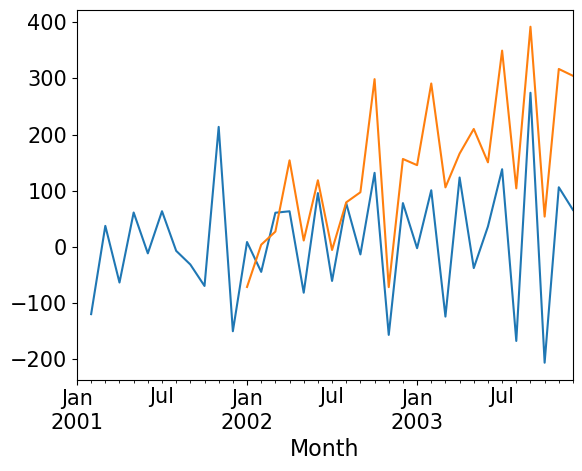

In [100]:
data['Sales First Difference'].plot()
data['Seasonal First Difference'].plot()

## acf pacf plots

In [59]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

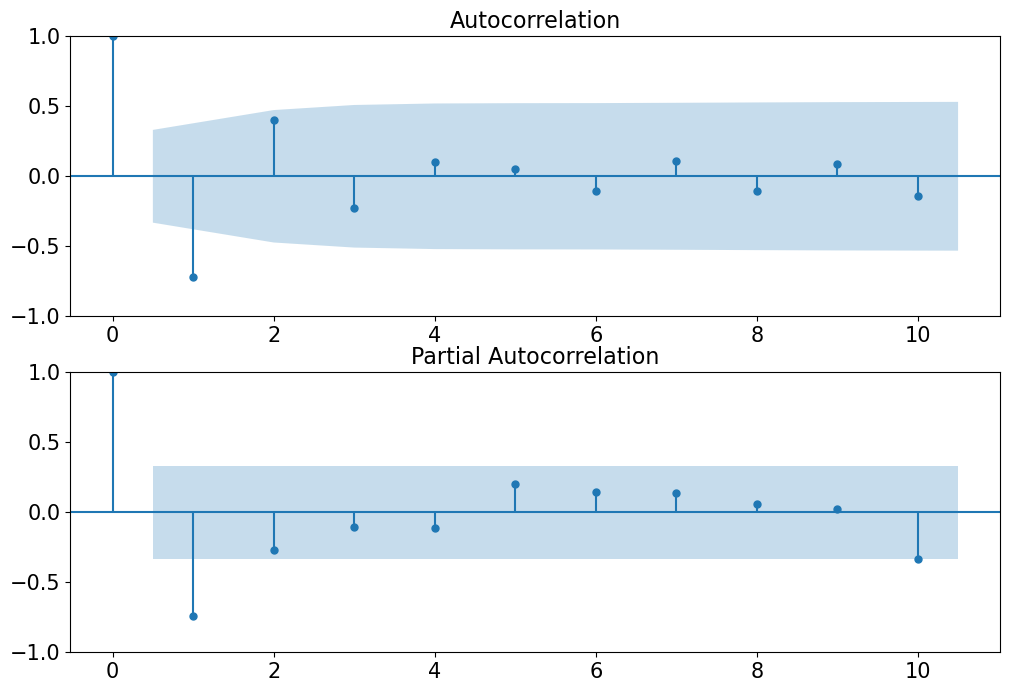

In [101]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data['Sales First Difference'].dropna(),lags=10,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data['Sales First Difference'].dropna(),lags=10,ax=ax2)

### Train Test Split

In [116]:
i=0.75
per=df.shape[0]*i
per

27.0

In [117]:
train = df.iloc[:int(per+1)]
test = df.iloc[int(per+1):]

In [118]:
print(train.shape[0])
train.tail()

28


,Sales
Month,
2002-12-01,342.3
2003-01-01,339.7
2003-02-01,440.4
2003-03-01,315.9
2003-04-01,439.3


In [119]:
print(test.shape[0])
test.head()

8


,Sales
Month,
2003-05-01,401.3
2003-06-01,437.4
2003-07-01,575.5
2003-08-01,407.6
2003-09-01,682.0


### pdq value iteration

In [102]:
import itertools

#### for loop over rmse

In [106]:
p=range(0,7)
d=range(1,2)
q=range(0,7)

pdq_combination=list(itertools.product(p,d,q))

In [107]:
len(pdq_combination)

49

In [128]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

In [150]:
order1=[]
rmse=[]

for pdq in pdq_combination:
    try:
        model=ARIMA(train,order=pdq).fit()
        pred=model.predict(start='2003-05-01',end='2003-12-01',dynamic=True)
        error=np.sqrt(mean_squared_error(test,pred))
        order1.append(pdq)
        rmse.append(error)
    except:
        continue

results=pd.DataFrame(index=order1,data=rmse,columns=['RMSE']).sort_values('RMSE')
results.head()

,RMSE
"(2, 1, 3)",129.754517
"(6, 1, 6)",134.380003
"(5, 1, 6)",134.380004
"(4, 1, 6)",134.380013
"(3, 1, 6)",134.380014


In [156]:
mod = ARIMA(train['Sales'], order=(2,1,3))

results_Arima = mod.fit()

In [157]:
predicted_autoARIMA = results_Arima.forecast(steps=len(test))
predicted_autoARIMA

2003-05-01    375.000822
2003-06-01    451.278838
2003-07-01    405.381705
2003-08-01    468.783455
2003-09-01    431.572485
2003-10-01    484.296182
2003-11-01    454.162133
2003-12-01    498.027401
Freq: MS, Name: predicted_mean, dtype: float64

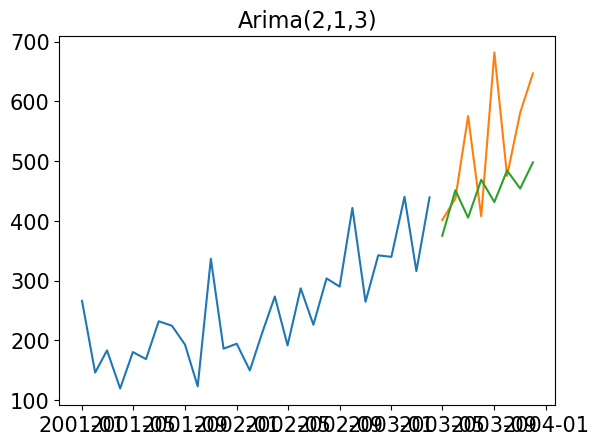

In [158]:
plt.plot(train,label='Training Data')
plt.plot(test,label='Test Data')
plt.plot(test.index,predicted_autoARIMA,label='Predicted Data - ARIMA')
plt.grid()
plt.title('Arima(2,1,3)')
plt.grid()

In [165]:
error=np.sqrt(mean_squared_error(test,predicted_autoARIMA))
print("Root mean squared error",error)

Root mean squared error 180.2009577438199


Best p,d,q = 2,1,3

#### Using AIC

In [160]:
ARIMA_AIC = pd.DataFrame(columns=['pdq', 'AIC'])

for pdq in pdq_combination:
    try:
        ARIMA_model = ARIMA(train['Sales'].values,order=pdq).fit()
        print('ARIMA{} - AIC:{}'.format(pdq,ARIMA_model.aic))
        ARIMA_AIC = ARIMA_AIC.append({'pdq':pdq, 'AIC': ARIMA_model.aic}, ignore_index=True)
    except:
        continue

ARIMA(0, 1, 0) - AIC:322.5549905951241
ARIMA(0, 1, 1) - AIC:310.3965714719568
ARIMA(0, 1, 2) - AIC:307.9389681612834
ARIMA(0, 1, 3) - AIC:308.5386709882739
ARIMA(0, 1, 4) - AIC:310.1906292262238
ARIMA(0, 1, 5) - AIC:306.92775757405667
ARIMA(0, 1, 6) - AIC:308.59991114202387
ARIMA(1, 1, 0) - AIC:307.8395071851736
ARIMA(1, 1, 1) - AIC:308.4509639906144
ARIMA(1, 1, 2) - AIC:308.7582632685198
ARIMA(1, 1, 3) - AIC:310.70113238111156
ARIMA(1, 1, 4) - AIC:308.64492998439374
ARIMA(1, 1, 5) - AIC:308.68535610535025
ARIMA(1, 1, 6) - AIC:310.4091833015971
ARIMA(2, 1, 0) - AIC:309.51824666374023
ARIMA(2, 1, 1) - AIC:310.29188128586435
ARIMA(2, 1, 2) - AIC:310.74542644218155
ARIMA(2, 1, 3) - AIC:310.3518924255845
ARIMA(2, 1, 4) - AIC:309.8755388307818
ARIMA(2, 1, 5) - AIC:311.7598278231609
ARIMA(2, 1, 6) - AIC:314.03973722352816
ARIMA(3, 1, 0) - AIC:306.9269335787829
ARIMA(3, 1, 1) - AIC:308.91328087619286
ARIMA(3, 1, 2) - AIC:305.372638542246
ARIMA(3, 1, 3) - AIC:306.9596254180014
ARIMA(3, 1, 4) -

In [161]:
ARIMA_AIC.sort_values('AIC').head(5)

,pdq,AIC
23,"(3, 1, 2)",305.372639
30,"(4, 1, 2)",306.881564
21,"(3, 1, 0)",306.926934
5,"(0, 1, 5)",306.927758
24,"(3, 1, 3)",306.959625


In [162]:
mod = ARIMA(train['Sales'], order=(3,1,2))

results_Arima = mod.fit()

In [163]:
predicted_autoARIMA = results_Arima.forecast(steps=len(test))
predicted_autoARIMA

2003-05-01    310.500261
2003-06-01    433.469242
2003-07-01    375.792393
2003-08-01    425.382194
2003-09-01    352.983134
2003-10-01    387.913360
2003-11-01    377.021054
2003-12-01    415.164607
Freq: MS, Name: predicted_mean, dtype: float64

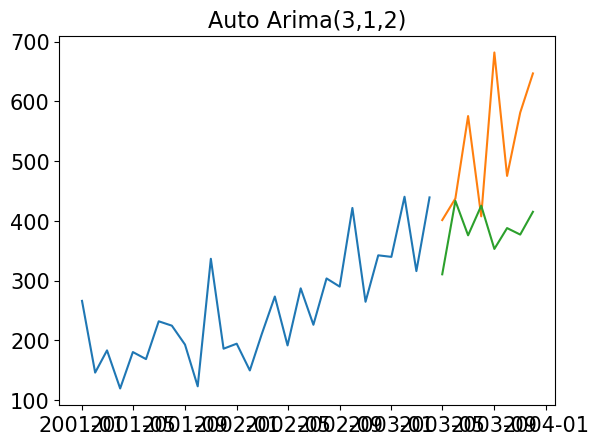

In [164]:
plt.plot(train,label='Training Data')
plt.plot(test,label='Test Data')
plt.plot(test.index,predicted_autoARIMA,label='Predicted Data - ARIMA')
plt.grid()
plt.title('Auto Arima(3,1,2)')
plt.grid()

In [167]:
error=np.sqrt(mean_squared_error(test,predicted_autoARIMA))
print("Root mean squared error",error)

Root mean squared error 180.2009577438199


### Creating model on whole data set and predicting

In [168]:
df.tail()

,Sales
Month,
2003-08-01,407.6
2003-09-01,682.0
2003-10-01,475.3
2003-11-01,581.3
2003-12-01,646.9


In [169]:
model = ARIMA(df['Sales'], order=(2,1,3)).fit()

predicted_autoARIMA = model.forecast(steps=24)
predicted_autoARIMA

2004-01-01    594.604223
2004-02-01    604.888497
2004-03-01    604.624964
2004-04-01    607.293563
2004-05-01    606.515965
2004-06-01    607.397383
2004-07-01    606.966075
2004-08-01    607.303688
2004-09-01    607.104763
2004-10-01    607.243064
2004-11-01    607.155955
2004-12-01    607.214107
2005-01-01    607.176605
2005-02-01    607.201289
2005-03-01    607.185237
2005-04-01    607.195750
2005-05-01    607.188894
2005-06-01    607.193377
2005-07-01    607.190450
2005-08-01    607.192362
2005-09-01    607.191113
2005-10-01    607.191929
2005-11-01    607.191396
2005-12-01    607.191745
Freq: MS, Name: predicted_mean, dtype: float64

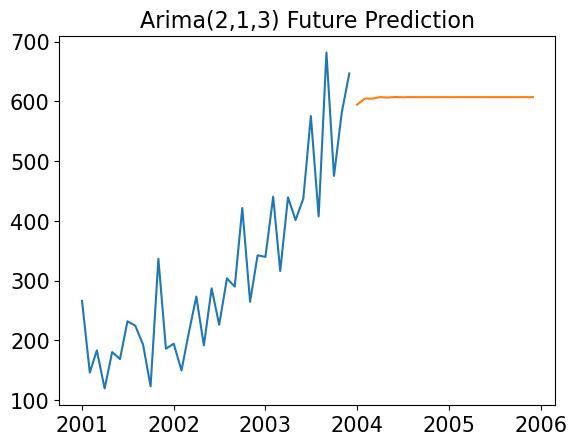

In [171]:
plt.plot(df,label='Actual data')
plt.plot(predicted_autoARIMA,label='Predicted Data - ARIMA')
plt.grid()
plt.title('Arima(2,1,3) Future Prediction')
plt.grid()

In [172]:
model = ARIMA(df['Sales'], order=(3,1,2)).fit()

predicted_autoARIMA = model.forecast(steps=24)
predicted_autoARIMA

2004-01-01    570.164145
2004-02-01    600.582696
2004-03-01    593.198723
2004-04-01    609.963213
2004-05-01    602.575719
2004-06-01    602.294513
2004-07-01    598.747831
2004-08-01    600.828992
2004-09-01    601.389063
2004-10-01    602.063683
2004-11-01    601.412148
2004-12-01    601.168767
2005-01-01    601.077099
2005-02-01    601.289836
2005-03-01    601.367844
2005-04-01    601.362630
2005-05-01    601.293595
2005-06-01    601.273440
2005-07-01    601.284655
2005-08-01    601.306275
2005-09-01    601.310078
2005-10-01    601.303962
2005-11-01    601.297559
2005-12-01    601.297416
Freq: MS, Name: predicted_mean, dtype: float64

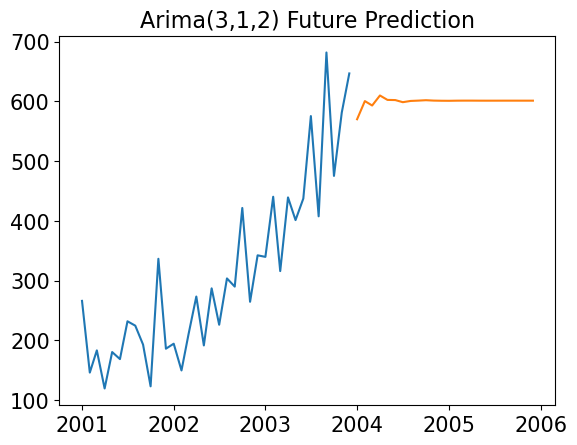

In [173]:
plt.plot(df,label='Actual data')
plt.plot(predicted_autoARIMA,label='Predicted Data - ARIMA')
plt.grid()
plt.title('Arima(3,1,2) Future Prediction')
plt.grid()

### Sarimax

In [175]:
model=sm.tsa.statespace.SARIMAX(df['Sales'],order=(2, 1, 3),seasonal_order=(2,1,3,12)).fit()

In [176]:
predicted_SARIMA = model.forecast(steps=24)
predicted_SARIMA

2004-01-01     539.167051
2004-02-01     632.797476
2004-03-01     568.112580
2004-04-01     746.418985
2004-05-01     619.988737
2004-06-01     728.018864
2004-07-01     751.367175
2004-08-01     687.169629
2004-09-01     904.741215
2004-10-01     891.469522
2004-11-01     728.162321
2004-12-01     878.011198
2005-01-01     868.565227
2005-02-01     979.306945
2005-03-01     833.220290
2005-04-01     968.829682
2005-05-01     936.973347
2005-06-01     961.039414
2005-07-01    1136.304914
2005-08-01     919.087132
2005-09-01    1259.686764
2005-10-01     997.918812
2005-11-01    1129.074530
2005-12-01    1186.187188
Freq: MS, Name: predicted_mean, dtype: float64

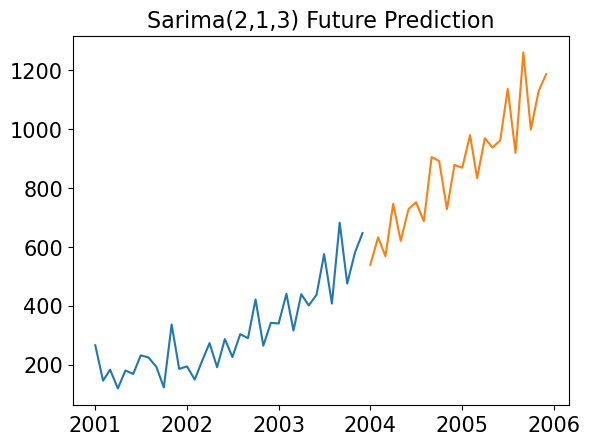

In [178]:
plt.plot(df,label='Actual data')
plt.plot(predicted_SARIMA,label='Predicted Data - ARIMA')
plt.grid()
plt.title('Sarima(2,1,3) Future Prediction')
plt.grid()

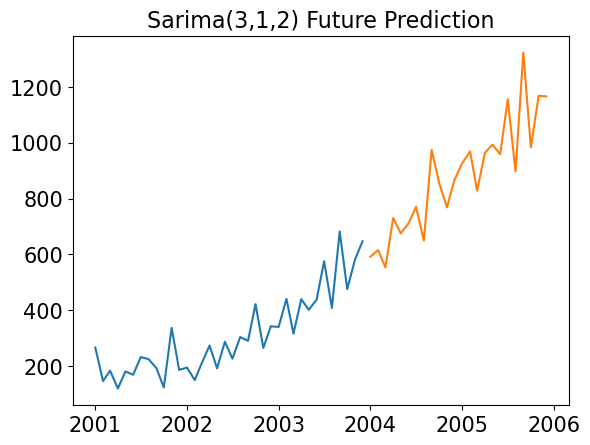

In [179]:
model=sm.tsa.statespace.SARIMAX(df['Sales'],order=(3, 1, 2),seasonal_order=(3,1,2,12)).fit()
predicted_SARIMA = model.forecast(steps=24)
plt.plot(df,label='Actual data')
plt.plot(predicted_SARIMA,label='Predicted Data - ARIMA')
plt.grid()
plt.title('Sarima(3,1,2) Future Prediction')
plt.grid()